# Emotion classification using the RAVDESS dataset

The RAVDESS contains 7356 files. Ratings were provided by 247 individuals.

***Description***

The dataset contains the complete set of 7356 RAVDESS files (total size: 24.8 GB). Each of the 24 actors consists of two modality formats: Audio-only (16bit, 48kHz .wav), Audio-Video (720p H.264, AAC 48kHz, .mp4).

***File naming convention***

Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics:

***Filename identifiers***

- Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
- Vocal channel (01 = speech, 02 = song).
- Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
- Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the ‘neutral’ emotion.
- Statement (01 = “Kids are talking by the door”, 02 = “Dogs are sitting by the door”).
- Repetition (01 = 1st repetition, 02 = 2nd repetition).
- Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

Filename example: 02-01-06-01-02-01-12.mp4 

- Video-only (02)
- Speech (01)
- Fearful (06)
- Normal intensity (01)
- Statement “dogs” (02)
- 1st Repetition (01)
- 12th Actor (12)
- Female, as the actor ID number is even.

# **Packages**

In [ ]:
!pip install pydub

In [ ]:
import librosa
from librosa import display

In [ ]:
from pydub import AudioSegment

In [ ]:
import matplotlib.pyplot as plt 
import os
import numpy as np

## **Connect to Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **One File**

In [ ]:
path = '/content/drive/MyDrive/Emotion/features/Actor_05/03-02-06-01-02-02-05.wav'

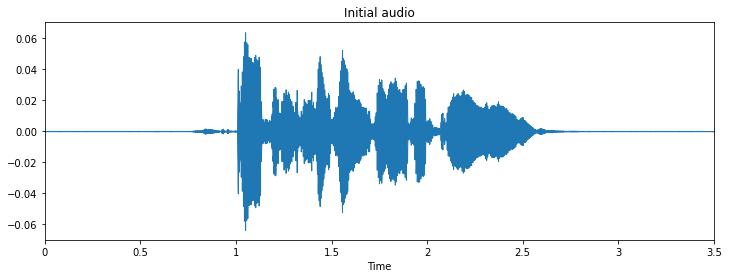

In [ ]:
rawsound = AudioSegment.from_file(path)
data, sampling_rate = librosa.load(path, sr = None)

plt.figure(figsize=(12,4))
librosa.display.waveplot(data, sampling_rate)
plt.title('Initial audio')

rawsound

# **Load all files**

We will create our numpy array extracting Mel-frequency cepstral coefficients (MFCCs), while the classes to predict will be extracted from the name of the file.

In [ ]:
import time

path = '/content/drive/MyDrive/Emotion/features'
lst = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
  for file in files:
      try:
        #Load librosa array, obtain mfcss, store the file and the mcss information in a new array
        X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
        # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
        # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
        file = int(file[7:8]) - 1 
        arr = mfccs, file
        lst.append(arr)
      # If the file is not valid, skip it
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 334.5253093242645 seconds ---


In [ ]:
# Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
X, y = zip(*lst)

In [ ]:
X = np.asarray(X)
y = np.asarray(y)

X.shape, y.shape

((5252, 40), (5252,))

In [ ]:
# Saving joblib files to not load them again with the loop above

import joblib

X_name = 'X.joblib'
y_name = 'y.joblib'
save_dir = '/content/drive/MyDrive/Emotion'

savedX = joblib.dump(X, os.path.join(save_dir, X_name))
savedy = joblib.dump(y, os.path.join(save_dir, y_name))

In [ ]:
# Loading saved models
import joblib

X = joblib.load('/content/drive/MyDrive/Emotion/X.joblib')
y = joblib.load('/content/drive/MyDrive/Emotion/y.joblib')

# **Neural network CNN**

Let's build our neural network!

To do so, we need to expand the dimensions of our array, adding a third one using the numpy "expand_dims" feature.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [ ]:
X_train.shape, X_test.shape

((3518, 40), (1734, 40))

In [ ]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)

In [ ]:
x_traincnn.shape, x_testcnn.shape

((3518, 40, 1), (1734, 40, 1))

## Model

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from tensorflow.keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import RMSprop 

model = Sequential()

model.add(Conv1D(128, 5, padding='same', input_shape=(40,1)))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))

model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Flatten())

model.add(Dense(8))
model.add(Activation('softmax'))

opt = RMSprop(learning_rate=0.00005, rho=0.9, epsilon=None, decay=0.0)

With *model.summary* we can see a recap of what we have build:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 40, 128)           768       
                                                                 
 activation_3 (Activation)   (None, 40, 128)           0         
                                                                 
 dropout_2 (Dropout)         (None, 40, 128)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 activation_4 (Activation)   (None, 5, 128)            0         
                                                      

Now we can compile and fit our model:

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=1000, validation_data=(x_testcnn, y_test))

Epoch 1/1000
220/220 [==============================] - 13s 6ms/step - loss: 5.1950 - accuracy: 0.2047 - val_loss: 1.7582 - val_accuracy: 0.3783
Epoch 2/1000
220/220 [==============================] - 1s 5ms/step - loss: 3.4842 - accuracy: 0.2959 - val_loss: 1.5466 - val_accuracy: 0.4769
Epoch 3/1000
220/220 [==============================] - 1s 4ms/step - loss: 2.5911 - accuracy: 0.3758 - val_loss: 1.4288 - val_accuracy: 0.4804
Epoch 4/1000
220/220 [==============================] - 1s 5ms/step - loss: 2.0755 - accuracy: 0.4210 - val_loss: 1.2240 - val_accuracy: 0.5681
Epoch 5/1000
220/220 [==============================] - 1s 4ms/step - loss: 1.7442 - accuracy: 0.4835 - val_loss: 1.1717 - val_accuracy: 0.6188
Epoch 6/1000
220/220 [==============================] - 1s 5ms/step - loss: 1.5380 - accuracy: 0.4977 - val_loss: 1.2157 - val_accuracy: 0.5467
Epoch 7/1000
220/220 [==============================] - 1s 5ms/step - loss: 1.4090 - accuracy: 0.5296 - val_loss: 1.1587 - val_accuracy

**Let's plot the loss:**

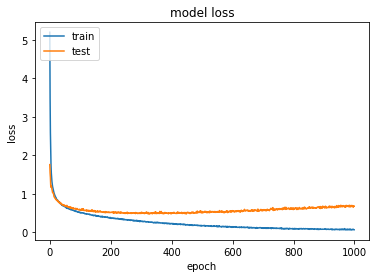

In [ ]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**And now let's plot the accuracy:**

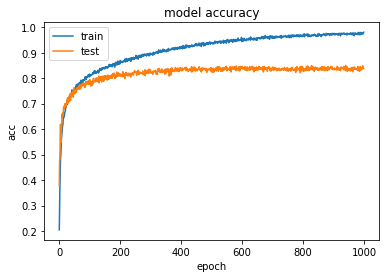

In [ ]:
plt.plot(cnnhistory.history['accuracy'])
plt.plot(cnnhistory.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Let's now create a classification report to review the f1-score of the model per class.
To do so, we have to:
- Create a variable predictions that will contain the model.predict_classes outcome
- Convert our y_test (array of strings with our classes) to an array of int called new_Ytest, otherwise it will not be comparable to the predictions by the classification report.

In [ ]:
predictions = model.predict(x_testcnn) 
classes_x = np.argmax(predictions,axis=1)

In [ ]:
classes_x

array([6, 6, 4, ..., 3, 0, 4])

In [ ]:
y_test

array([6, 7, 0, ..., 3, 0, 4])

In [ ]:
new_Ytest = y_test.astype(int)

In [ ]:
new_Ytest

array([6, 7, 0, ..., 3, 0, 4])

Okay, now we can display the classification report:

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(new_Ytest, classes_x)
print(report)

              precision    recall  f1-score   support

           0       0.86      0.92      0.89       189
           1       0.79      0.71      0.75       124
           2       0.83      0.82      0.82       243
           3       0.86      0.78      0.82       239
           4       0.84      0.90      0.86       267
           5       0.82      0.80      0.81       264
           6       0.81      0.86      0.83       202
           7       0.89      0.89      0.89       206

    accuracy                           0.84      1734
   macro avg       0.84      0.83      0.83      1734
weighted avg       0.84      0.84      0.84      1734



And now, the confusion matrix: it will show us the misclassified samples

In [ ]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(new_Ytest, classes_x)
print (matrix)

# 0 = neutral, 1 = calm, 2 = happy, 3 = sad, 4 = angry, 5 = fearful, 6 = disgust, 7 = surprised

[[173   4   1   8   1   0   2   0]
 [  8  88  11   2   5   5   5   0]
 [  1   5 199   4  11  13   6   4]
 [ 13   9   5 186   4  14   4   4]
 [  0   2   6   0 239   6  12   2]
 [  2   4   9  13  12 211   7   6]
 [  0   0   5   4   8   4 174   7]
 [  3   0   4   0   6   4   6 183]]


# Save the model

In [ ]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = '/content/drive/MyDrive/Emotion'
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/Emotion/Emotion_Voice_Detection_Model.h5 


# Reloading the model to test it

In [ ]:
loaded_model = keras.models.load_model('/content/drive/MyDrive/Emotion/Emotion_Voice_Detection_Model.h5')
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, 40, 128)           768       
                                                                 
 activation_3 (Activation)   (None, 40, 128)           0         
                                                                 
 dropout_2 (Dropout)         (None, 40, 128)           0         
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 5, 128)           0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 5, 128)            82048     
                                                                 
 activation_4 (Activation)   (None, 5, 128)            0         
                                                      

# Checking the accuracy of the loaded model

In [ ]:
loss, acc = loaded_model.evaluate(x_testcnn, y_test)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

55/55 [==============================] - 0s 2ms/step - loss: 0.6788 - accuracy: 0.8379
Restored model, accuracy: 83.79%


# Thank you for your attention! To be continued..